In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from vqvae.model import MNISTModel 

In [2]:
BATCH_SIZE = 16
EPOCHS = 15

C = 3
W = 28
H = 28

N_CODEBOOK = 256
DIM_CODEBOOK = 32

channel_sizes = [16, 32]
strides = [2, 2]

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

dataset = datasets.CIFAR10("./datasets/CIFAR10", train=True, download=True, transform=transforms.ToTensor())
dataset_val = datasets.CIFAR10("./datasets/CIFAR10", train=False, download=True, transform=transforms.ToTensor())

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import pytorch_lightning as pl

class LITVqvae(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.model = model
        self.hist = {
            "loss": [],
            "rank": [],
        }
        
    def training_step(self, batch, batch_idx):
        images, labels = batch
        encodings = self.model.encode(images)
        qt = self.model.quanticize(encodings)

        
        loss_latent = torch.nn.functional.mse_loss(encodings, qt)
        
        n_uniques = len(qt.permute(0, 2, 3, 1).view(-1, DIM_CODEBOOK).unique(dim=0))
        
        qt = encodings + (qt - encodings).detach()
        
        reconstructions = self.model.decode(qt)

        loss = torch.nn.functional.mse_loss(images, reconstructions)
        loss = loss + loss_latent
                
        self.hist['loss'].append(loss.item())
        self.hist['rank'].append(n_uniques)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(self.lr))

In [5]:
model = MNISTModel(in_channel=3, channel_sizes=channel_sizes,
                   n_codebook=N_CODEBOOK,
                   dim_codebook=DIM_CODEBOOK,
                   strides=strides)
train_model = LITVqvae(model, lr=1e-3)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1)
trainer.fit(train_model, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | MNISTModel | 26.2 K
-------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

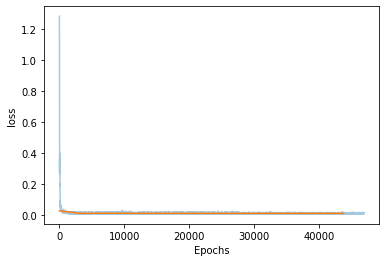

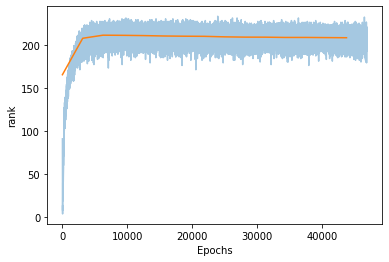

In [6]:
# loss = np.array(train_model.hist["loss"])

for loss_name, loss_values in train_model.hist.items():
    loss_values = np.array(loss_values)
    plt.plot(loss_values, alpha=.4)
    plt.plot(np.arange(0, len(loss_values), len(dataloader)), loss_values.reshape(EPOCHS, len(dataloader)).mean(-1))
    plt.xlabel("Epochs")
    plt.ylabel(loss_name)
    plt.show()

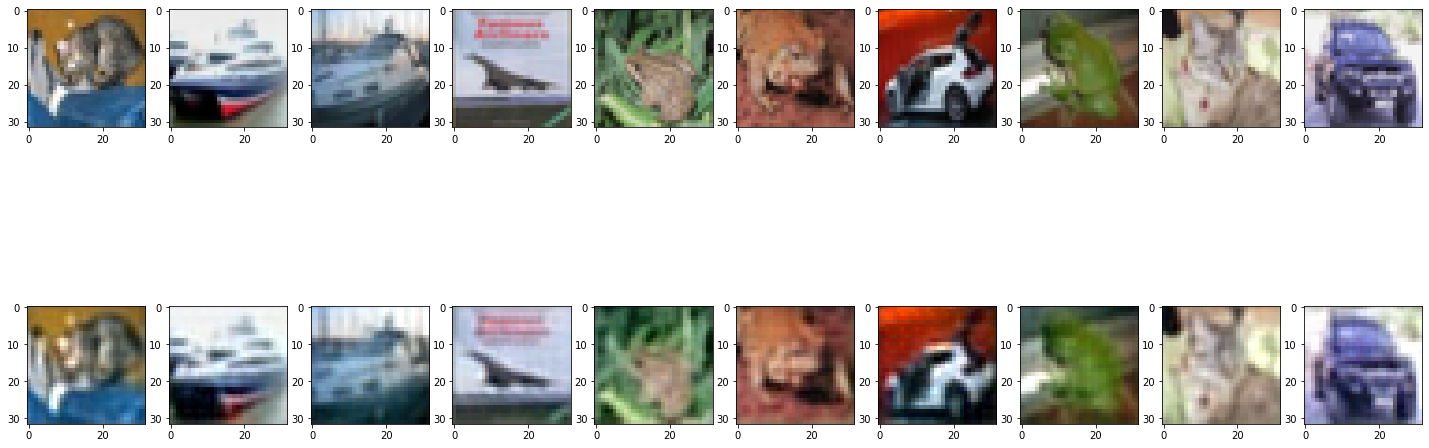

In [7]:
n_images = 10

for images, labels in dataloader_val:
    break
images = images[:n_images]
with torch.no_grad():
    reconstructions = model(images).clip(0, 1)
    
# fig, axes = plt.subplots(nrows=2, ncols=n_images)
plt.figure(figsize=(25, 10))
for idx, (image, reconstruction) in enumerate(zip(images, reconstructions)):
    plt.subplot(2, n_images, idx+1)
    plt.imshow(image.permute(1, 2, 0))
    
    plt.subplot(2, n_images, n_images+idx+1)
    plt.imshow(reconstruction.permute(1, 2, 0))

In [9]:
loss = []
for batch in dataloader_val:
    with torch.no_grad():
        images, labels = batch
        encodings = model.encode(images)
        qt = model.quanticize(encodings)
        reconstructions = model.decode(qt)

        loss.append(torch.nn.functional.mse_loss(images, reconstructions))
np.array(loss).mean()

0.00616011